In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INPUT_SIZE = [128,128]
BATCH = 32

In [3]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2
)
training_data = training_datagen.flow_from_directory(
    'D:\codes\DL@personal\data\Face Mask Dataset\Train',
    target_size = INPUT_SIZE,
    batch_size = BATCH,
    class_mode = 'binary'
)


Found 10000 images belonging to 2 classes.


<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lalsa\AppData\Local\Temp\ipykernel_6656\3900830294.py:7: SyntaxWarning: invalid escape sequence '\c'
  'D:\codes\DL@personal\data\Face Mask Dataset\Train',


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    'D:\codes\DL@personal\data\Face Mask Dataset\Test',
    target_size = INPUT_SIZE,
    batch_size = BATCH,
    class_mode = 'binary'
)

Found 992 images belonging to 2 classes.


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lalsa\AppData\Local\Temp\ipykernel_6656\1814010501.py:3: SyntaxWarning: invalid escape sequence '\c'
  'D:\codes\DL@personal\data\Face Mask Dataset\Test',


 Input shape here is [255,255,3] so we manually add that [3] to our earlierly used input size, so the new input_shape for our vgg16 model is INPUT_SIZE + [3]

In [5]:
base_model = VGG16(
    input_shape = INPUT_SIZE + [3],
    weights = 'imagenet',
    include_top = False
)

In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

##### Since we are interested in a strategic Transfer Learning here, we freeze the weights. Instead we manually add a couple of DNN layers whose weights will be effected during back propagation 

In [32]:
flatten = Flatten()(base_model.output)
d_layer_1 = Dense(units=500, activation='relu')(flatten)
d_layer_2 = Dense(units=500, activation='relu')(d_layer_1)
d_layer_3 = Dense(units=100, activation='relu')(d_layer_2)
d_layer_4 = Dense(units=100, activation='relu')(d_layer_3)
final_dense_output = Dense(units=1, activation='sigmoid')(d_layer_4)


In [33]:
final_model = Model(
    inputs=base_model.input,
    outputs = final_dense_output
    ) 
final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           10

 Total params: 19,121,989 (72.94 MB)

 Trainable params: 4,407,301 (16.81 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training the Model

In [34]:
final_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [35]:
batch_size = 15
fitting = final_model.fit(
    training_data,
    validation_data = test_data,
    epochs = 10,
    steps_per_epoch = len(training_data)//batch_size,
    validation_steps = len(test_data)//batch_size
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 602ms/step - accuracy: 0.7289 - loss: 0.5316 - val_accuracy: 1.0000 - val_loss: 0.0193
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - accuracy: 0.9728 - loss: 0.0840 - val_accuracy: 0.9531 - val_loss: 0.0608
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9758 - loss: 0.0460 - val_accuracy: 0.9844 - val_loss: 0.0138
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.9778 - loss: 0.1099 - val_accuracy: 0.9688 - val_loss: 0.0375
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 707ms/step - accuracy: 0.9964 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 702ms/step - accuracy: 0.9786 - loss: 0.0527 - val_accuracy: 0.9375 - val_loss: 0.1704
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 720ms/step - accuracy: 0.9604 - loss: 0.1060 - val_accuracy: 0.9844 - val_loss: 0.0926
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - accuracy: 0.9791 - loss: 0.0570 - val_accu

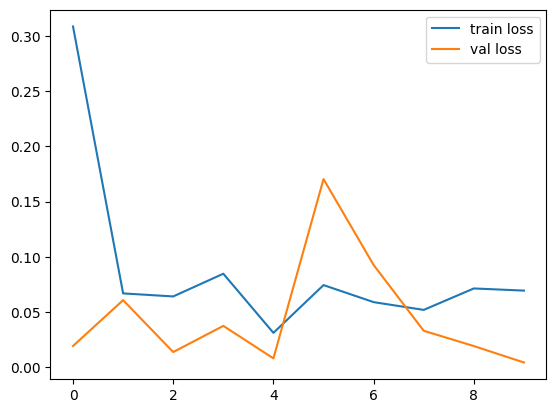

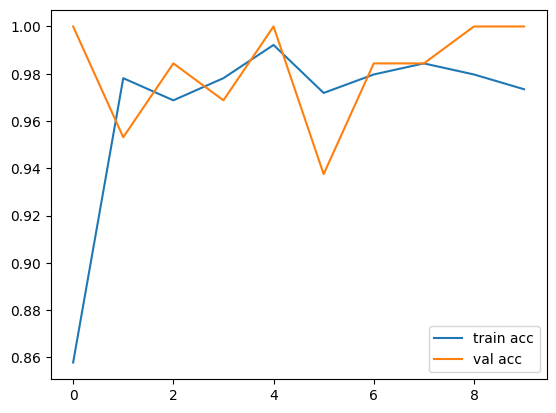

<Figure size 640x480 with 0 Axes>

In [36]:
#plot the loss
plt.plot(fitting.history['loss'], label='train loss')
plt.plot(fitting.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(fitting.history['accuracy'], label='train acc')
plt.plot(fitting.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
output = lambda x: 'Image classified as WithMAsk' if x<0.5 else 'Image classified as Without Mask'

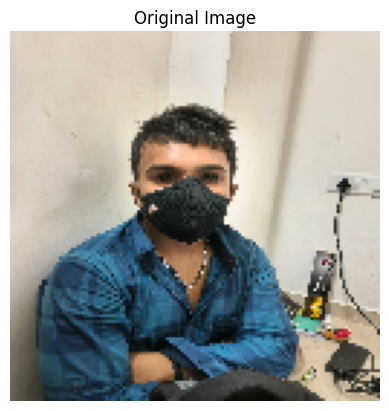

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


'Image classified as WithMAsk'

In [38]:
path_test_img = r'D:\codes\DL@personal\test_image_with_mask.jpg'
sample_image = image.load_img(path_test_img, target_size=INPUT_SIZE)
plt.imshow(sample_image)
plt.title('Original Image')
plt.axis('off')  # Hide the axis
plt.show()
sample_image = image.img_to_array(sample_image)
sample_image = sample_image/255
sample_image = np.expand_dims(sample_image, axis=0)
result = final_model.predict(sample_image)
output(result)

In [43]:
from sklearn.metrics import classification_report
predicted_prob = final_model.predict(sample_image)
predicted_label = (predicted_prob < 0.5).astype(int).flatten()

# Example true label (replace this with the actual label)
true_label = [1]  # Assuming the true class is 1 for this example
print(predicted_prob)
# Generate a classification report
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.00084936]]
[1]


In [74]:
# Define paths to the directories
masked_dir = r'D:\codes\DL@personal\data\Face Mask Dataset\Test\WithMask'
not_masked_dir = r'D:\codes\DL@personal\data\Face Mask Dataset\Test\WithoutMask'
gallery = []
true_labels = []
predicted_probs = []

In [75]:
for img in os.listdir(masked_dir):
    gallery.append(img)
    true_labels.append(1)

In [76]:
for img in os.listdir(not_masked_dir):
    gallery.append(img)
    true_labels.append(0)

In [77]:
indices = list(range(len(true_labels)))
np.random.shuffle(indices)

In [78]:
plate = 'D:\codes\DL@personal\data\Face Mask Dataset\Test'
for j in indices:

    addrrss = gallery[j]
    if true_labels[j]==1: 
        addrrss = plate + '\WithMask' + f'\{addrrss}'
    elif true_labels[j]==0:
        addrrss = plate + '\WithoutMask' + f'\{addrrss}'
    img_ = image.load_img(addrrss, target_size=INPUT_SIZE)
    img_ = image.img_to_array(img_)
    img_ = img_/255
    img_ = np.expand_dims(img_, axis=0)
    result = final_model.predict(img_)
    predicted_probs.append(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<string>:6: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\{'
<string>:6: SyntaxWarning: invalid escape sequence '\{'
<string>:8: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\{'
C:\Users\lalsa\AppData\Local\Temp\ipykernel_6656\997039317.py:1: SyntaxWarning: invalid escape sequence '\c'
  plate = 'D:\codes\DL@personal\data\Face Mask Dataset\Test'
C:\Users\lalsa\AppData\Local\Temp\ipykernel_6656\997039317.py:6: SyntaxWarning: invalid escape sequence '\

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

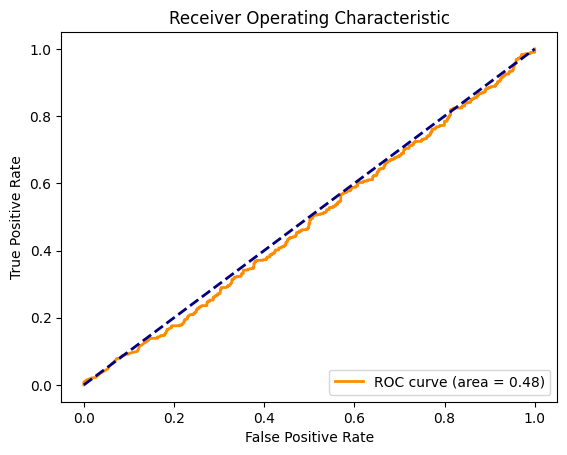

Optimal threshold: 3.2977168302750215e-05


In [81]:
predicted_probs = np.ravel(predicted_probs)
true_labels = np.ravel(true_labels)

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Find the best threshold (You can choose the threshold with the maximum tpr - fpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the optimal threshold
print(f'Optimal threshold: {optimal_threshold}')

In [85]:
"{:.6f}".format(optimal_threshold)

'0.000033'